In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import scipy.sparse as sparse
import scipy.linalg as linalg
from scipy.sparse.linalg import LinearOperator
import numpy as np
import collections
import copy

import amfe
from amfe.utils.utils import OrderedSet
from amfe.cyclic.cyclic import SelectionOperator, apply_cyclic_symmetry, get_all_dofs, rotate_u, set_cyclic_modes_to_component
from amfe.cyclic.cyclic import create_voigt_rotation_matrix, assemble_cyclic_modes, cyclic_symmetry_modal_analysis, Cyclic_Symmetry_Modal_Analysis
from amfe.cyclic.cyclic import create_rotated_component, create_voigt_rotation_matrix, Cyclic_Component
from amfe.utils.utils import get_dofs
from amfe.linalg.arnoldi import arnoldi_iteration, inverse_arnoldi_iteration, general_inverse_arnoldi_iteration, generalized_arnoldi_iteration
from amfe.linalg.arnoldi import lanczos, is_eigvec, nullspace, LinearSys, power_iteration, ProjLinearSys, compute_modes, eigvec_error_vector, is_nullspace
from amfe.linalg.arnoldi import is_moore_pensore_inverse, ProjPrecondLinearSys
from amfe.contact import Cyclic_Contact
from amfe.units import convert
import pandas as pd
import logging 
from amfe.wrappers.ansys_wrapper import read_ansys_sparse_matrix

#msh_file = r'meshes\one_forth_disk_quad.msh'
#theta = np.pi/2.0 #

cases_dict = {}

cases_dict[1] =  {'msh_file' : r'meshes\simple_blade_disc.inp', 'msh_obj' : r'amfe_mesh_obj\simple_blade_disc.pkl',
                  'theta' : np.pi/4.0,
                  'scale' : 1000,
                  'tol_radius' : 1.0e-3,
                   'bc' : np.array([-50,50])}

cases_dict[2] = {'msh_file' : r'meshes\3D_simple_bladed_disk.inp', 'msh_obj' : r'amfe_mesh_obj\3D_simple_bladed_disk.pkl',
                 'theta' : 2*np.pi/81.0,
                 'scale' : 1000,
                 'tol_radius' : 1.1e0,
                 'bc' : np.array([-300,300])}


cases_dict[3] = {'msh_file' : r'meshes\3D_simple_bladed_disk_course.inp', 'msh_obj' : r'amfe_mesh_obj\3D_simple_bladed_disk_course.pkl',
                 'theta' : 2*np.pi/81.0,
                 'scale' : 1000,
                 'tol_radius' : 1.1e0,
                 'bc' : np.array([-300,300])}


cases_dict[4] = {'msh_file' : r'meshes\3D_simple_bladed_disk_24_sectors_course.inp', 'msh_obj' : r'amfe_mesh_obj\3D_simple_bladed_disk_24_sectors_course.pkl',
                 'theta' : 2*np.pi/24,
                 'scale' : 1000,
                 'tol_radius' : 1.1e0,
                 'bc' : np.array([-300,300])}

cases_dict[5] = {'msh_file' : r'meshes\3D_simple_bladed_disk_24_sectors_course_V2.inp', 'msh_obj' : r'amfe_mesh_obj\3D_simple_bladed_disk_24_sectors_course_V2.pkl',
                 'theta' : 2*np.pi/24,
                 'scale' : 1000,
                 'tol_radius' : 1.1e0,
                 'bc' : np.array([-200,200])}

cases_dict[6] = {'msh_file' : r'meshes\3d_simple_bladed_disk_24_sector.msh', 'msh_obj' : r'amfe_mesh_obj\3D_simple_bladed_disk_24_sectors_gmsh.pkl',
                 'theta' : 2*np.pi/24,
                 'scale' : 1,
                 'tol_radius' : 0.1e0,
                 'bc' : np.array([-200,200])}

#unpack case dict
case_id = 6
msh_file = cases_dict[case_id]['msh_file']
msh_obj = cases_dict[case_id]['msh_obj']
theta = cases_dict[case_id]['theta']
scale = cases_dict[case_id]['scale']
n_sector = int((2.0*np.pi)/abs(theta))
tol_radius = cases_dict[case_id]['tol_radius']
bc = cases_dict[case_id]['bc']

try:
    m = amfe.load_obj(msh_obj)
except:
    m = amfe.Mesh()
    if case_id==6:
        m.import_msh(msh_file,scale)
    else:
        m.import_inp(msh_file,scale)
    amfe.save_object(m,msh_obj)

Python was not able to load the fast fortran assembly routines.

Python was not able to load the fast fortran material routines.



<IPython.core.display.Javascript object>


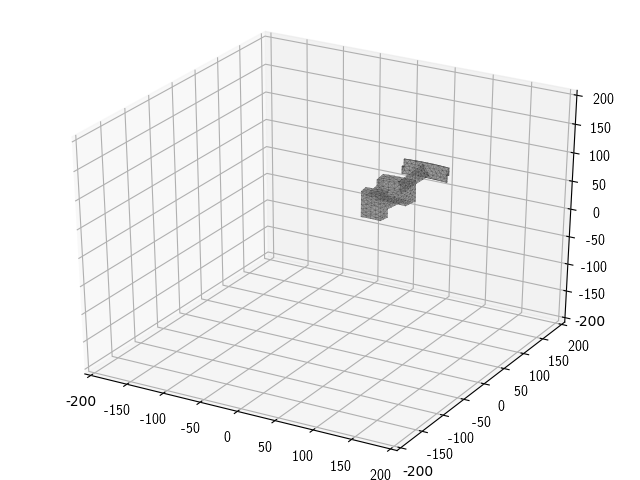

(-200, 200)

In [2]:
pltmsh = amfe.Plot3DMesh(m,boundaries=False,plot_nodes=False,alpha=0.5)
pltmsh.show()
pltmsh.ax.set_xlim(bc)
pltmsh.ax.set_ylim(bc)
pltmsh.ax.set_zlim(bc)

In [3]:
m.get_phys_group_types()

{1, 2, 3, 4}

In [4]:

    
dirsub = m.get_submesh('phys_group', 1)
cyclic_left = m.get_submesh('phys_group', 3)
cyclic_right = m.get_submesh('phys_group', 2)
m.get_phys_group_types()

{1, 2, 3, 4}

<IPython.core.display.Javascript object>


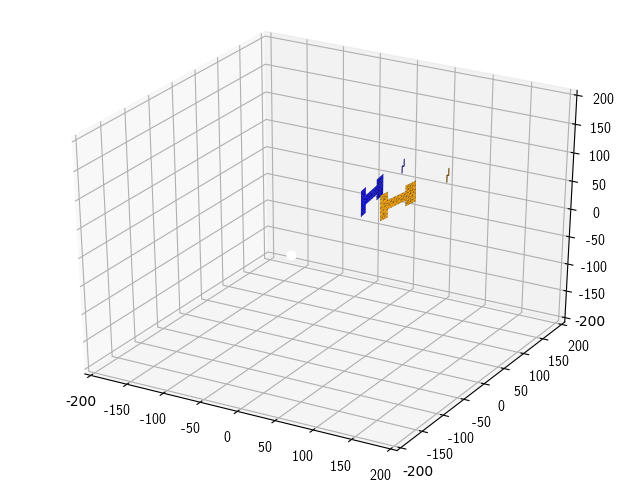

In [5]:
ax2 = amfe.plot3D_submesh(cyclic_left,alpha=1,plot_nodes=False,linewidth=0.1,color='blue')
ax2.set_xlim(bc)
ax2.set_ylim(bc )
ax2.set_zlim(bc)
amfe.plot3D_submesh(cyclic_right,alpha=1,plot_nodes=False,linewidth=0.1,color='orange',ax=ax2)


In [6]:
contact = Cyclic_Contact(cyclic_left,cyclic_right,sector_angle=theta, unit='rad',tol_radius = tol_radius)


<IPython.core.display.Javascript object>


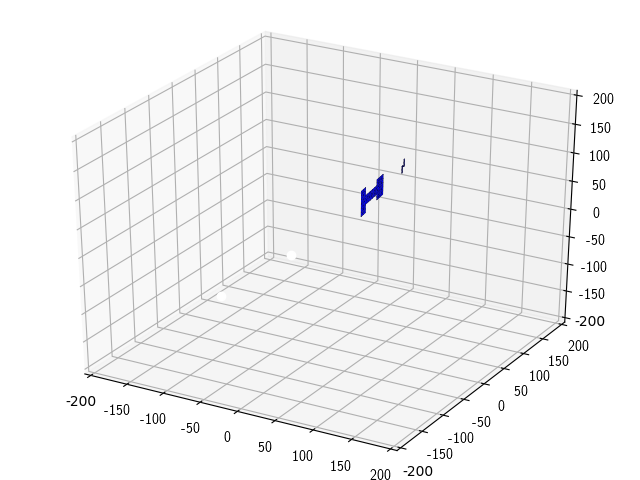

In [7]:
ax3 = amfe.plot3D_submesh(contact.virtual_slave,alpha=1,plot_nodes=False,linewidth=0.1,color='grey')
#bc = np.array([0,300])
ax3.set_xlim(bc)
ax3.set_ylim(bc )
ax3.set_zlim(bc)
amfe.plot3D_submesh(cyclic_left,alpha=1,plot_nodes=False,linewidth=0.1,color='blue',ax=ax3)

In [8]:
# creating a mechanical component
my_comp = amfe.MechanicalSystem()
my_comp.set_mesh_obj(m)
rho = 7.86E-9 # kg/mm3
E = 210.0E3 # MPa = N/mm2
my_material = amfe.KirchhoffMaterial(E=E, nu=0.3, rho=rho, plane_stress=False)
my_comp.set_domain(4,my_material)

print('Number of nodes is equal to %i' %my_comp.mesh_class.no_of_nodes)


Preallocating the stiffness matrix
Done preallocating stiffness matrix with 1560 elements and 1854 dofs.
Time taken for preallocation: 0.03 seconds.
Number of nodes is equal to 618


In [9]:
n_modes = 10
cyclic_obj = Cyclic_Symmetry_Modal_Analysis(my_comp,
                               dirsub,
                               cyclic_left,
                               cyclic_right,
                               sector_angle=theta,
                               unit='rad',
                               tol_radius = tol_radius, 
                               node_diam_range = (0,3),
                               n_modes=n_modes)

comp_list = cyclic_obj.comp_ND_list
s = cyclic_obj.selector_operator


xyz direction choosen for cyclic symmetry


<IPython.core.display.Javascript object>


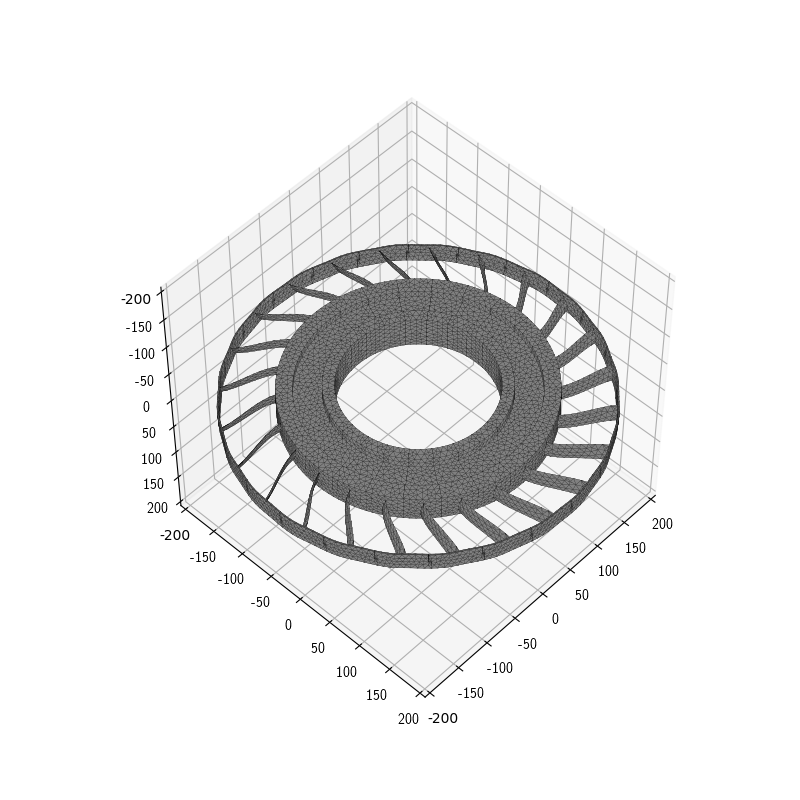

interactive(children=(FloatSlider(value=0.1, description='factor', max=1.0, min=-1.0, step=0.05), IntSlider(va…

In [10]:
from ipywidgets import interact
import mpl_toolkits.mplot3d as a3


def create_sector_list(my_comp,node_diam):
    sector_list = []
    for i in range(n_sector):
        sector_i = create_rotated_component(my_comp,s,sector_id=i, node_id=node_diam, theta=-theta, unit='rad', dimension=3)
        sector_list.append(sector_i)
    return sector_list

def plot_sector_list(sector_list, ax1):
    ax1.clear()
    plot_list = []
    reference = True
    for sector_i in sector_list:
        displacement = sector_i.u_output
        m_i = sector_i.mesh_class
        if reference:
            #amfe.plot_system_solution(sector_i, factor=100*factor, ax = ax1, u_id = mode_id, facecolor=0.8*np.array((1,1,1)))    
            pltmesh = amfe.Plot3DMesh(m_i,scale=1, displacement_list = displacement, ax = ax1, alpha=1,edgecolor='black',linewidth=0.1)   
            collections=[]
            reference = False
        else:
            
            
            #amfe.plot_system_solution(sector_i, factor=100*factor, ax = ax1, u_id = mode_id)
            pltmesh = amfe.Plot3DMesh(m_i,scale=1, displacement_list = displacement, ax = ax1, alpha=1,edgecolor='black',linewidth=0.1)   
            collections = pltmesh.ax.collections
        
        plot_list.append(pltmesh)
        
    return plot_list

node_id_selected = 0
sector_list_0 = create_sector_list(comp_list[0],node_id_selected)
sector_list_1 = create_sector_list(comp_list[1],node_id_selected)
sector_list_2 = create_sector_list(comp_list[2],node_id_selected)

fig0 = plt.figure(figsize=(8,8))
ax0 = fig0.add_subplot(1,1,1,projection='3d')
plt_list_0 = plot_sector_list(sector_list_0, ax0)
plt_list_1 = plot_sector_list(sector_list_1, ax0)
plt_list_2 = plot_sector_list(sector_list_2, ax0)
plt_list_primal = [plt_list_0,plt_list_1,plt_list_2]

ax0.set_xlim(bc)
ax0.set_ylim(bc)
ax0.set_zlim(bc)
@interact(factor=(-1.0,1.0,0.05),mode_id=(0,n_modes,1),node_id_selected=(0,3,1))
def plot2(factor=0.1,mode_id=0,node_id_selected=0):
    
    plt_list_0 = plt_list_primal[node_id_selected]
    collections = []
    for plot_obj in plt_list_0 :
        plot_obj.show(factor=10000*factor,plot_nodes=False,displacement_id=mode_id, collections=collections)
        
    


In [11]:
cyclic_comp = Cyclic_Component(my_comp,
                      dirsub,
                      cyclic_left,
                      cyclic_right,
                      sector_angle=theta,
                      unit='rad',
                      tol_radius = tol_radius)

P_n_0 = cyclic_comp.build_complex_projection(0)
P_n_1 = cyclic_comp.build_complex_projection(1)
P_n_2 = cyclic_comp.build_complex_projection(2)

K_sector, M_sector = cyclic_comp.assemble_sector_operators()
s = cyclic_comp.s

xyz direction choosen for cyclic symmetry


C:\Users\ge72tih\AppData\Local\Continuum\anaconda3\envs\ndcsi\lib\site-packages\scipy\sparse\compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [12]:
n_modes = 20
ndofs = cyclic_comp.ndofs
nc = cyclic_comp.nc
dimension = my_comp.mesh_class.no_of_dofs_per_node
no_of_dofs = K_sector.shape[0]
fill_perc = 0.2
drop_tol = 1.0E-6
#K_inv = sparse.linalg.inv(K_sector)
#K_pinv = P_n.dot(K_inv).dot(P_n)
#P_n_inv = sparse.csc_matrix(np.linalg.pinv(P_n.toarray()))
res_dict = {}
P_n_list = [P_n_0,P_n_1,P_n_2]
for i in range(len(P_n_list)):
    
    P_n = P_n_list[i]

    Kp = P_n.conj().T.dot(K_sector.dot(P_n))
    scipy_K_inv = sparse.csc_matrix(np.linalg.pinv(Kp.toarray()))

    
    I = sparse.eye(ndofs)
    
    pre_obj1 = ProjPrecondLinearSys(K_sector,P_n, incomplete=True, fill_factor = int(fill_perc*no_of_dofs), drop_tol=drop_tol )
    pre_obj2 = ProjPrecondLinearSys(K_sector,P_n, incomplete=False )
    pre_obj3 = ProjPrecondLinearSys(K_sector,I, incomplete=True, fill_factor = int(fill_perc*no_of_dofs), drop_tol=drop_tol )
    pre_obj4 = ProjPrecondLinearSys(K_sector,I, incomplete=False )
    #pre_obj5 = ProjPrecondLinearSys(Kp,I, incomplete=False )
    
    #lu = sparse.linalg.splu(K_sector)
    #lui = sparse.linalg.spilu(K_sector)
    #lun = sparse.linalg.splu(Kp)

    precond0 = I
    precond1 = pre_obj1.getLinearOperator()
    precond2 = pre_obj2.getLinearOperator()
    precond3 = pre_obj3.getLinearOperator()
    precond4 = pre_obj4.getLinearOperator()
    #precond5 = pre_obj5.getLinearOperator()
    precond5 = scipy_K_inv

    list_precond = [precond0,
                   precond1,
                   precond2,
                   precond3,
                   precond4,
                   precond5]

    for j in range(len(list_precond)): #
        precond_j = list_precond[j]
        lo_obj = ProjLinearSys(K_sector,M_sector,P_n,precond_j)
        Dp_new = lo_obj.getLinearOperator()
        w2new, v2new = sparse.linalg.eigs(Dp_new, k=n_modes)
        new_id = np.argsort(w2new)[::-1]
        w2new = w2new[new_id]
        v2new = v2new[:,new_id]

        u_vnew = assemble_cyclic_modes(s,v2new,node_id=i,compute_left=False,dimension=dimension)
        #u_vnew = assemble_cyclic_modes(s,v2new,node_id=i,compute_left=False,dimension=2)
        comp_i = copy.deepcopy(my_comp)
        comp_i.u_output = []
        comp_i.u_output = list(u_vnew.T)
        local_dict = {}
        local_dict['comp']= comp_i
        local_dict['linearOp'] = lo_obj
        local_dict['TotalLienarOpCall'] = lo_obj.num_iters
        local_dict['AvgLienarOpCall'] = lo_obj.num_iters/lo_obj.solver_counter
        local_dict['eigenvalues'] = 1.0/w2new
        local_dict['omega'] = np.sqrt(1.0/w2new.real)
        local_dict['frequency'] = np.sqrt(1.0/w2new.real)/(2.0*np.pi)
        local_dict['SolverCalls'] = lo_obj.solver_counter
        res_dict[i,j] =local_dict


C:\Users\ge72tih\AppData\Local\Continuum\anaconda3\envs\ndcsi\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt
C:\Users\ge72tih\AppData\Local\Continuum\anaconda3\envs\ndcsi\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in sqrt


In [13]:
res_dict

{(0, 0): {'comp': <amfe.mechanical_system.MechanicalSystem at 0x21f9a2b0f28>,
  'linearOp': <amfe.linalg.arnoldi.ProjLinearSys at 0x21f9a2b0e80>,
  'TotalLienarOpCall': 122346,
  'AvgLienarOpCall': 1942.0,
  'eigenvalues': array([2.53366682e+07+1.00866249e-03j, 6.75026573e+07+3.88263950e-05j,
         5.50330126e+08-7.06364520e-04j, 1.90501600e+09-9.32529288e-05j,
         2.13832093e+09+4.75035790e-03j, 3.03411417e+09-1.80513182e-03j,
         3.70157937e+09-9.75613555e-03j, 9.76069128e+09-2.79926622e-03j,
         1.06044661e+10-1.73930831e-02j, 1.24956727e+10+6.62159196e-03j,
         1.29377968e+10-8.88953399e-03j, 1.65539952e+10+3.33757191e-03j,
         2.82367925e+10-2.93197999e-02j, 4.20223418e+10-3.54845233e-02j,
         4.76974877e+10+6.32874043e-03j, 5.16648888e+10+2.87328876e-02j,
         5.28733159e+10+4.54654741e-03j, 5.87237451e+10-4.07411518e-02j,
         6.57195266e+10-6.23111463e-02j, 6.91541672e+10+2.89235686e-02j]),
  'omega': array([  5033.55423279,   8216.00007

In [14]:
def create_sector_list(my_comp,node_diam):
    sector_list = []
    for i in range(n_sector):
        sector_i = create_rotated_component(my_comp,s,sector_id=i, node_id=node_diam, theta=theta, unit='rad', dimension=3)
        sector_list.append(sector_i)
    return sector_list

def plot_sector_list(sector_list, ax1):
    ax1.clear()
    plot_list = []
    reference = True
    highlight = int(n_sector/2)
    for k,sector_i in enumerate(sector_list):
        displacement = sector_i.u_output
        m_i = sector_i.mesh_class
        if reference:
            #amfe.plot_system_solution(sector_i, factor=100*factor, ax = ax1, u_id = mode_id, facecolor=0.8*np.array((1,1,1)))    
            pltmesh = amfe.Plot3DMesh(m_i,scale=1, displacement_list = displacement, ax = ax1, 
                                      alpha=1,edgecolor=np.array((1,1,1))*0.75,linewidth=0.4,color=np.array((1,1,1)))   
                                      #alpha=1,edgecolor='black',linewidth=0.5,color=np.array((1,1,1))*0.75)   
            collections=[]
            reference = False
        else:
            
            
            #amfe.plot_system_solution(sector_i, factor=100*factor, ax = ax1, u_id = mode_id)
            pltmesh = amfe.Plot3DMesh(m_i,scale=1, displacement_list = displacement, ax = ax1, 
                                      alpha=1,edgecolor=np.array((1,1,1))*0.75,linewidth=0.4,color=np.array((1,1,1)))   
            collections = pltmesh.ax.collections
        
        if k==highlight:
            pltmesh.edgecolor='black' 
            pltmesh.linewidth=0.4,
            pltmesh.color=np.array((1,1,1))*0.75
        
        plot_list.append(pltmesh)
        
        
    return plot_list
        
precond_id = 2        
comp2new_1 = res_dict[0,precond_id]['comp']
comp2new_2 = res_dict[1,precond_id]['comp']
comp2new_3 = res_dict[2,precond_id]['comp']
sector_list_1 = create_sector_list(comp2new_1,0)
sector_list_2 = create_sector_list(comp2new_2,1)
sector_list_3 = create_sector_list(comp2new_3,2)
sector_list = [sector_list_1,
               sector_list_2,
               sector_list_3]



<IPython.core.display.Javascript object>


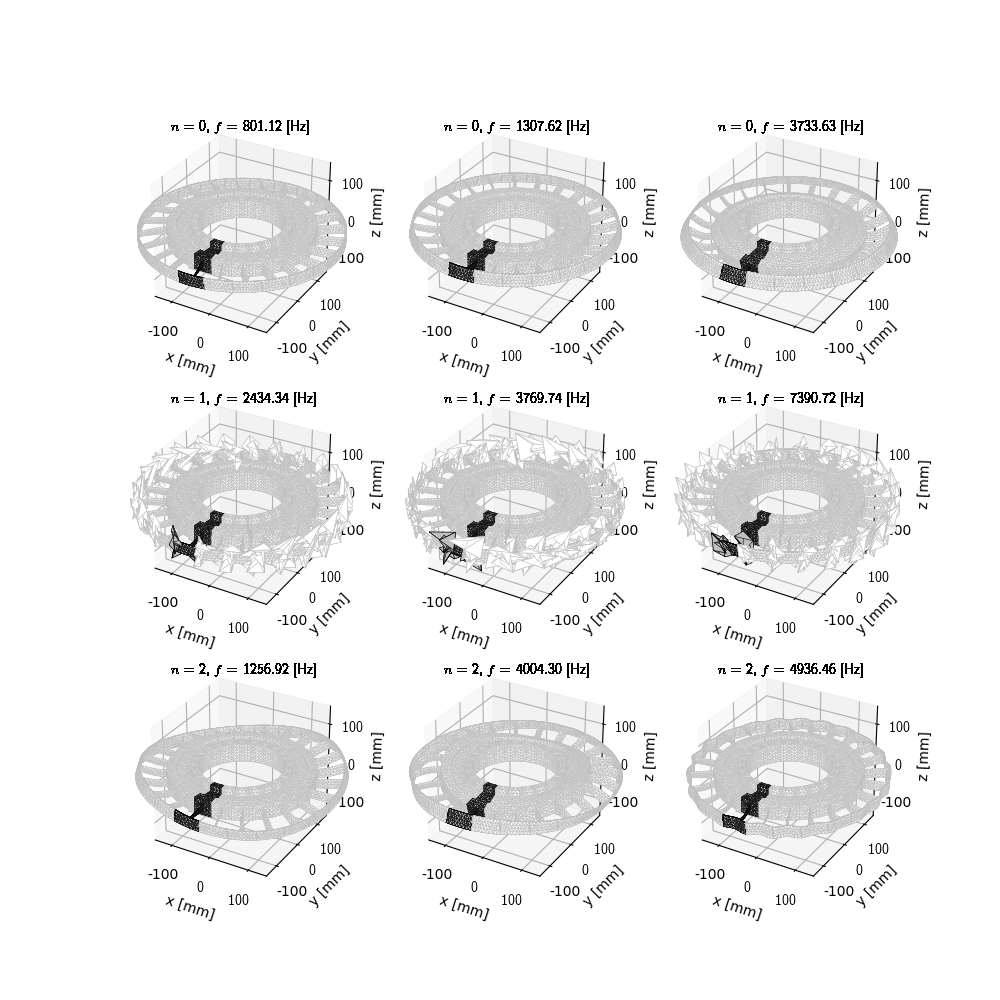

interactive(children=(FloatSlider(value=-0.75, description='factor', max=1.0, min=-1.0, step=0.05), IntSlider(…

In [15]:
from ipywidgets import interact
import mpl_toolkits.mplot3d as a3

fig1 = plt.figure(figsize=(10,10))
axes_list = []
plt_list = []
counter = 0
for i in range(3):
    for j in range(3):
        ax_i = fig1.add_subplot(3,3,counter+1,projection='3d')
        axes_list.append(ax_i)
        plt_list.append(plot_sector_list(sector_list[i], ax_i))
        counter += 1
plt.rc('text', usetex=True)

@interact(factor=(-1.0,1.0,0.05),mode_id=(0,n_modes,1))
def plot2(factor=-0.75,mode_id=0):
    #ax1.clear()
    #for sector_i in sector_list:
    #    amfe.plot_system_solution(sector_i, factor=10*factor, ax = ax1, u_id = mode_id)
    #bc = np.array([-250,250])*.6
    global bc
    i = 0
    j = 0
    for plt_list_i in plt_list:
        collections = []
        
        for plot_obj in plt_list_i:
            plot_obj.show(factor=1000*factor,plot_nodes=False,displacement_id=mode_id+i, collections=collections)
            plot_obj.set_equal_axis_lim(bc*0.7)
            plot_obj.ax.set_xlabel('x [mm]')
            plot_obj.ax.set_ylabel('y [mm]')
            plot_obj.ax.set_zlabel('z [mm]')
            #plot_obj.ax.set_title('$n$ = %i, $omega& = %f ' %(j,res_dict[j,precond_id]['omega'][i]))
            #plot_obj.ax.text(0,0,0, '$n$ = %i, $omega& = %f ' %(j,res_dict[j,precond_id]['omega'][i]))
            #label_str = r'$n$ = %i, $\omega$ = %0.2f [rad/s]' %(j,res_dict[j,precond_id]['omega'][i].real)
            label_str = r'$n$ = %i, $f$ = %0.2f [Hz]' %(j,res_dict[j,precond_id]['frequency'][i].real)
            #transform=ax.transAxes
            plot_obj.ax.text2D(0.2, 0.95, label_str, transform=plot_obj.ax.transAxes)
        if i<2:
            i+=1
        else:
            i=0
            j+=1

In [19]:
columns = []
for i in range(len(P_n_list)):
    columns.append('ND' + str(i))
    
index = ['I','$P(incK)^{-1}P$','$PK^{-1}P$','inc(K)^-1','K^-1','(PK^P)^-1']


data = np.zeros((len(list_precond),len(P_n_list)),dtype=np.float)

for i in range(len(P_n_list)):
    for j in range(len(list_precond)):
        data[j,i] = res_dict[i,j]['AvgLienarOpCall']
        
df = pd.DataFrame(data, index=index, columns=columns)

df

,ND0,ND1,ND2
I,1942.000000,1905.587302,1632.238095
$P(incK)^{-1}P$,689.936508,449.079365,474.444444
$PK^{-1}P$,350.142857,415.500000,89.682540
inc(K)^-1,806.038462,177.761905,474.507937
K^-1,350.253968,84.825397,362.968254
(PK^P)^-1,333.884615,1.015873,1.015873


In [17]:
print('Number of dofs is equal to %i ' %K_sector.shape[0])

Number of dofs is equal to 1731 


In [18]:
int(n_sector/2)

12